# Baseline predictions


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, SimpleRNN, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
import io
import math
warnings.filterwarnings("ignore")

In [84]:
df = pd.read_csv("adolescent#008.csv")
df.Time = pd.to_datetime(df.Time)
df = df[0:2480] # this final data from some of pacients are not relevant(stays at hipo for to long to be real)
df.set_index("Time")
df.head()

,Time,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
0,2020-07-06 12:00:00,144.3,148.140290,0.0,0.0093,0.0,2.158992,2.158992
1,2020-07-06 12:03:00,144.3,150.077653,0.0,0.0093,0.0,2.158992,2.158992
2,2020-07-06 12:06:00,144.3,150.080919,0.0,0.0093,0.0,2.158992,2.158992
3,2020-07-06 12:09:00,144.3,149.078710,0.0,0.0093,0.0,2.158992,2.158992
4,2020-07-06 12:12:00,144.3,147.395466,0.0,0.0093,0.0,2.158992,2.158992


In [85]:
def read_pacient(age="adolescent#0", number="08", extension=".csv", training_test_proportion=0.8,input_len=20, output_len=6):

  # reading the file
  df = pd.read_csv(age+number+extension)
  df.Time = pd.to_datetime(df.Time)
  df = df[0:2480] # this final data from some of pacients are not relevant(stays at hipo for to long to be real)
  df.set_index("Time")

  # Getting only blood glucuse from sensor data
  data = df.filter(['CGM'])
  dataset = data.values

  training_data_len = math.ceil( len(dataset) *training_test_proportion) # setting proportion for training and testing

  # Scalling data from 0 - 1 to input in the neural network
  scaler = MinMaxScaler(feature_range=(0, 1)) 
  scaled_data = scaler.fit_transform(dataset)

  train_data = scaled_data[0:training_data_len  , : ] 

  x_train=[] # arrays of blood glucose with len of input_len
  y_train = [] # arrays of blood glucose with len of output_len
  for i in range(input_len,len(train_data)-output_len):
      x_train.append(train_data[i-input_len:i,0]) # past blood glucose to learn
      y_train.append(train_data[i:i+output_len,0]) # future blood glucose to predict

  x_train, y_train = np.array(x_train), np.array(y_train) # converting to numpy array
  '''
  Reshape is necessary so the neural network can understand the data
  Shape will be (number of predictions, input_len, number of features)
  Feature is which property we are using in the model, so in this case it is only the blood glucose from the pacient
  '''
  x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

  not_scaled_test_data = dataset[training_data_len - input_len: , : ]
  test_data = scaled_data[training_data_len - input_len: , : ]

  x_test = [] # arrays of blood glucose with len of input_len
  y_test = [] # arrays of blood glucose with len of output_len
  continuous_ytest = [] # list with not scaled blood glucose from y_test not broken into arrays

  '''
  So here in the looping of the test we are predicting output_len values
  then the next output_len values so we can create a continuos plot of the 
  predicted glucose
  '''
  i = input_len
  while (i >= input_len and i < len(test_data)-output_len):
    x_test.append(test_data[i-input_len:i,0])
    y_test.append(not_scaled_test_data[i:i+output_len,0])
    for bg in not_scaled_test_data[i:i+output_len,0]:
      continuous_ytest.append(bg) # not for testing, just for plot purpose
    i = i+output_len # jump output_len values in the future

  x_test = np.array(x_test) # converting to numpy array
  x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

  return scaler, x_train, y_train, x_test, y_test, continuous_ytest

In [86]:
def show_plots(continuous_ytest, continuous_predictions):
  plt.figure(figsize=(16,8))
  plt.title('Blood Glucose Prediction Model Result')
  plt.plot(continuous_ytest, color = 'b')
  plt.plot(continuous_predictions, color = 'r')
  plt.xlabel('Timestamp',fontsize=18)
  plt.ylabel('BGBG (mg/dL)',fontsize=18)
  plt.legend(['Real','Predictions'], loc='lower right')
  plt.show()

In [87]:
def test_model(model, age="adolescent#0", number="01", extension=".csv",input_len=20, output_len=6):

  # reading the file
  df = pd.read_csv(age+number+extension)
  df.Time = pd.to_datetime(df.Time)
  df = df[0:2480] # this final data from some of pacients are not relevant(stays at hipo for to long to be real)
  df.set_index("Time")

  # Getting only blood glucuse from sensor data
  data = df.filter(['CGM'])
  dataset = data.values

  # Scalling data from 0 - 1 to input in the neural network
  scaler = MinMaxScaler(feature_range=(0, 1)) 
  scaled_data = scaler.fit_transform(dataset)

  x_test = [] # arrays of blood glucose with len of input_len
  y_test = [] # arrays of blood glucose with len of output_len
  continuous_ytest = [] # list with not scaled blood glucose from y_test not broken into arrays

  i = input_len
  while (i >= input_len and i < len(dataset)-output_len):
    x_test.append(scaled_data[i-input_len:i,0])
    y_test.append(dataset[i:i+output_len,0])
    for bg in dataset[i:i+output_len,0]:
      continuous_ytest.append(bg) # not for testing, just for plot purpose
    i = i+output_len # jump output_len values in the future

  x_test = np.array(x_test) # converting to numpy array
  x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

  predictions = model.predict(x_test) # make predictions
  predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

  predictions = scaler.inverse_transform(predictions) # reverse data

  # Create a continuous data of predictions to plot with continuous_ytest
  continuous_predictions = predictions[0]
  for i in range(1,len(predictions)):
    continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

  rmse=np.sqrt(np.mean(((predictions-y_test)**2)))


  return rmse, continuous_ytest, continuous_predictions

# Linear Predictions

In [88]:
def linear_predictions(scaler, x_train, y_train, x_test, y_test, batch_size=1, epochs=1):

  model = Sequential([
      Flatten(input_shape=(x_train.shape[1],1)),
      Dense(units=y_train.shape[1])
  ])

  model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

  predictions = model.predict(x_test) # make predictions
  predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

  predictions = scaler.inverse_transform(predictions) # reverse data

  # Create a continuous data of predictions to plot with continuous_ytest
  continuous_predictions = predictions[0]
  for i in range(1,len(predictions)):
    continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

  rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

  return model, predictions, continuous_predictions, rmse

In [89]:
scaler, x_train, y_train, x_test, y_test, continuous_ytest = read_pacient() # standard parameters are for pacient number 8

In [90]:
model, predictions, continuous_predictions, rmse = linear_predictions(scaler, x_train, y_train, x_test, y_test,batch_size=100, epochs=100)

Epoch 1/100
20/20 [==============================] - 0s 975us/step - loss: 0.9151 - accuracy: 0.1205
Epoch 2/100
20/20 [==============================] - 0s 908us/step - loss: 0.6863 - accuracy: 0.1956
Epoch 3/100
20/20 [==============================] - 0s 964us/step - loss: 0.5090 - accuracy: 0.1742
Epoch 4/100
20/20 [==============================] - 0s 983us/step - loss: 0.3795 - accuracy: 0.1767
Epoch 5/100
20/20 [==============================] - 0s 948us/step - loss: 0.2817 - accuracy: 0.1772
Epoch 6/100
20/20 [==============================] - 0s 930us/step - loss: 0.2097 - accuracy: 0.1828
Epoch 7/100
20/20 [==============================] - 0s 960us/step - loss: 0.1561 - accuracy: 0.1721
Epoch 8/100
20/20 [==============================] - 0s 940us/step - loss: 0.1158 - accuracy: 0.1711
Epoch 9/100
20/20 [==============================] - 0s 903us/step - loss: 0.0869 - accuracy: 0.1578
Epoch 10/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy


### Patient 08 Test

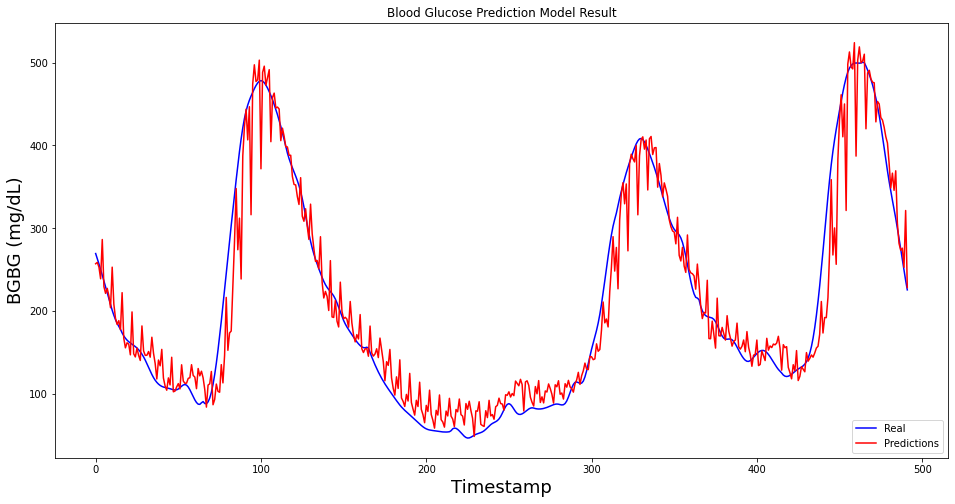

In [91]:
show_plots(continuous_ytest, continuous_predictions)

In [92]:
print("Root-Mean-Squared Deviation {}".format(rmse))

Root-Mean-Squared Deviation 34.20490192258596


In [93]:
rmse12, continuous_ytes12, continuous_predictions12 = test_model(model)

### Patient 01 predictions

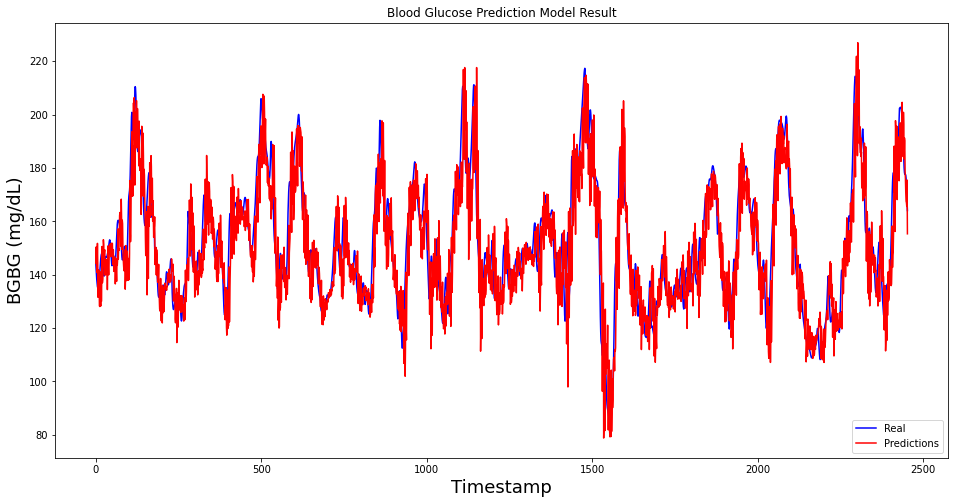

Root-Mean-Squared Deviation 12.248013253304554


In [94]:
show_plots(continuous_ytes12, continuous_predictions12)
print("Root-Mean-Squared Deviation {}".format(rmse12))

In [95]:
rmse13, continuous_predictions13, continuous_ytes13 = test_model(model,number="10")

### Patient 10 predictions

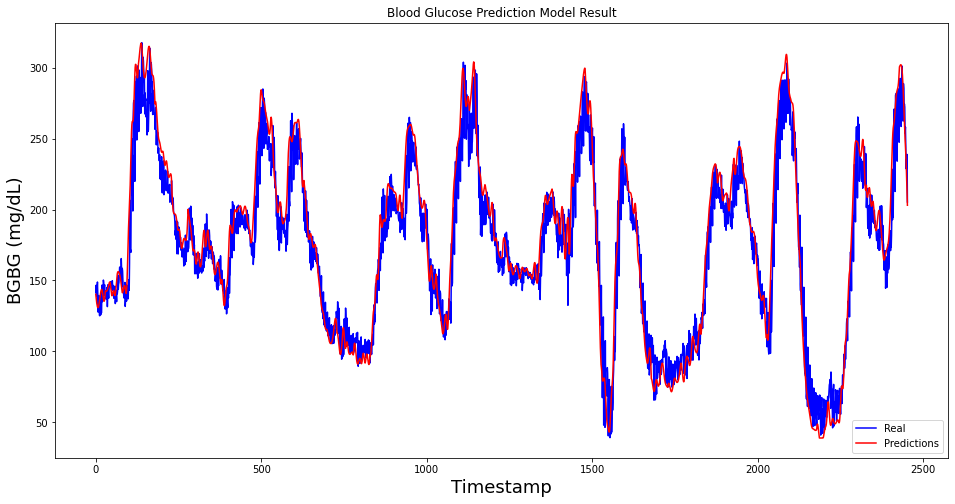

Root-Mean-Squared Deviation 17.72262334518164


In [96]:
show_plots(continuous_ytes13, continuous_predictions13)
print("Root-Mean-Squared Deviation {}".format(rmse13))

### Patient 07 predictions

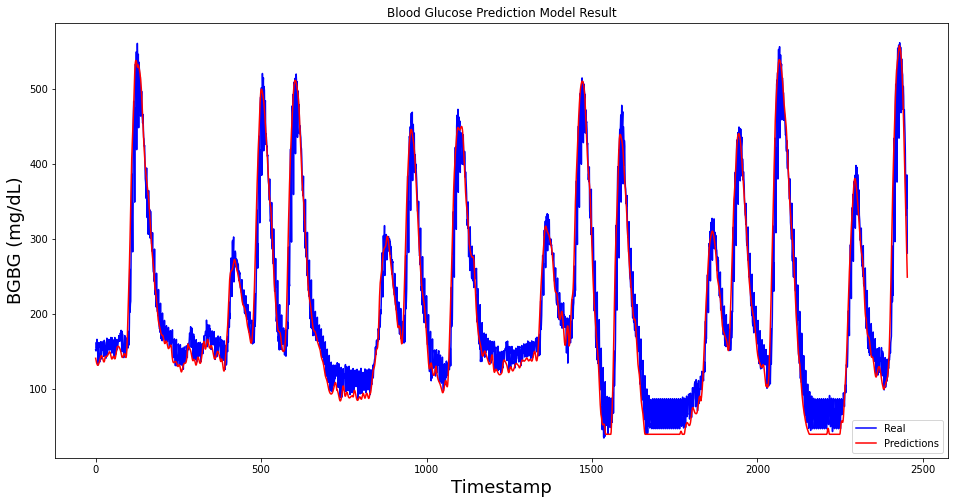

Root-Mean-Squared Deviation 33.06549327524622


In [97]:
rmse14, continuous_predictions14, continuous_ytes14 = test_model(model,number="07")
show_plots(continuous_ytes14, continuous_predictions14)
print("Root-Mean-Squared Deviation {}".format(rmse14))

# Simple RNN

In [98]:
def simpleRNN_predictions(scaler, x_train, y_train, x_test, y_test, batch_size=1, epochs=1):

  model = Sequential([
      SimpleRNN(1, input_shape=(x_train.shape[1],1)),
      Dense(units=y_train.shape[1])
  ])

  model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

  predictions = model.predict(x_test) # make predictions
  predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

  predictions = scaler.inverse_transform(predictions) # reverse data

  # Create a continuous data of predictions to plot with continuous_ytest
  continuous_predictions = predictions[0]
  for i in range(1,len(predictions)):
    continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

  rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

  return model, predictions, continuous_predictions, rmse

In [99]:
model2, predictions2, continuous_predictions2, rmse2 = simpleRNN_predictions(scaler, x_train, y_train, x_test, y_test,batch_size=10, epochs=100)

Epoch 1/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0966 - accuracy: 0.1144
Epoch 2/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0429 - accuracy: 0.1353
Epoch 3/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0282 - accuracy: 0.1078
Epoch 4/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0225 - accuracy: 0.0552
Epoch 5/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0191 - accuracy: 0.0465
Epoch 6/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0166 - accuracy: 0.0363
Epoch 7/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0143 - accuracy: 0.0363
Epoch 8/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0123 - accuracy: 0.0373
Epoch 9/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0105 - accuracy: 0.0373
Epoch 10/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0090 - accura

### Patient 08 Test

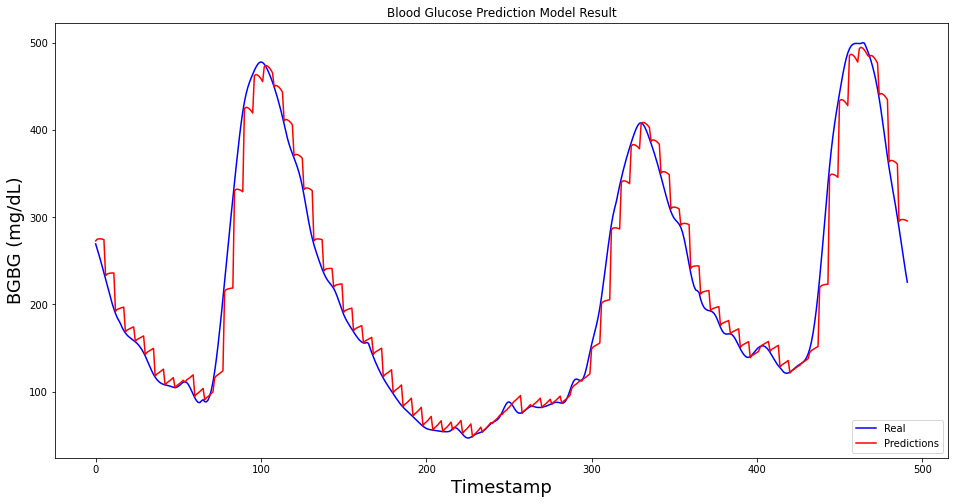

In [100]:
show_plots(continuous_ytest, continuous_predictions2)

In [101]:
print("Root-Mean-Squared Deviation {}".format(rmse2))

Root-Mean-Squared Deviation 23.59759821204999


In [102]:
rmse22, continuous_ytes22, continuous_predictions22 = test_model(model2)

### Patient 01 predictions

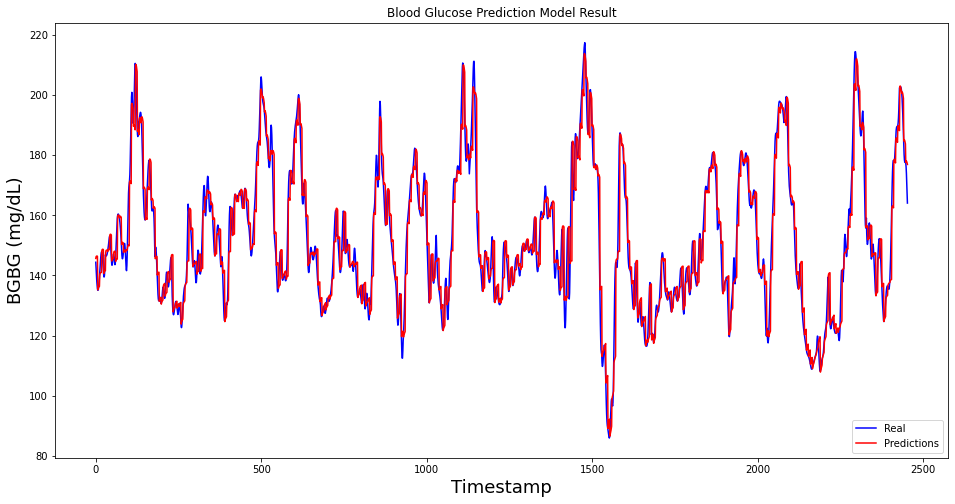

Root-Mean-Squared Deviation 6.997614830557574


In [103]:
show_plots(continuous_ytes22, continuous_predictions22)
print("Root-Mean-Squared Deviation {}".format(rmse22))

In [104]:
rmse23, continuous_ytes23, continuous_predictions23 = test_model(model2,number="10")

### Patient 10 predictions

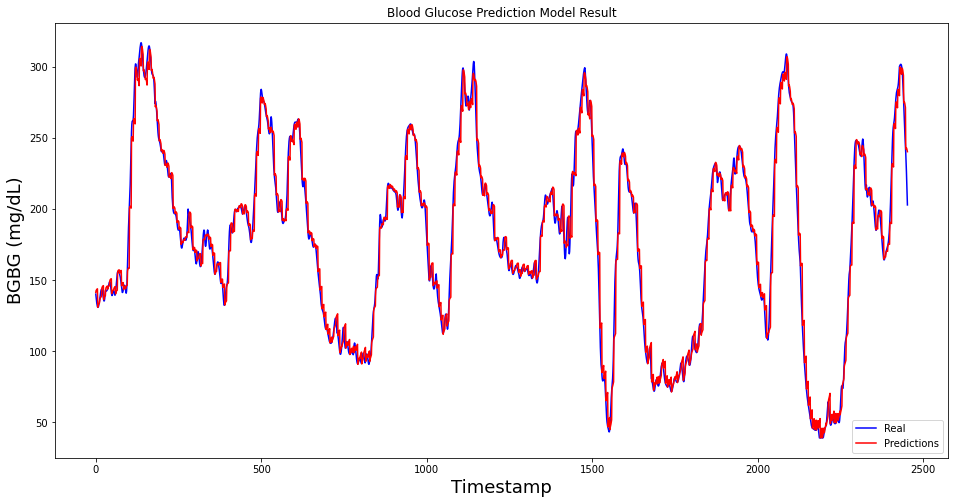

Root-Mean-Squared Deviation 9.632075100387139


In [105]:
show_plots(continuous_ytes23, continuous_predictions23)
print("Root-Mean-Squared Deviation {}".format(rmse23))

### Patient 07 predictions

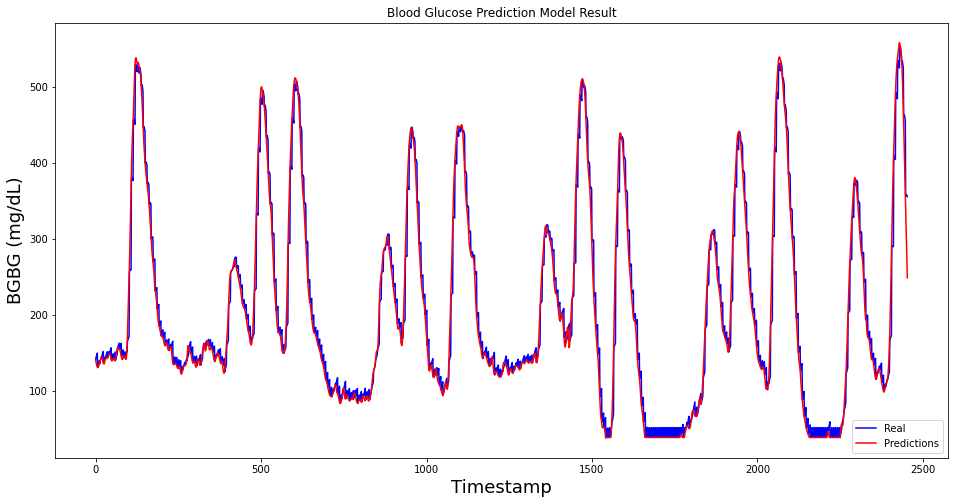

Root-Mean-Squared Deviation 21.854630697766375


In [106]:
rmse24, continuous_predictions24, continuous_ytes24 = test_model(model2,number="07")
show_plots(continuous_ytes24, continuous_predictions24)
print("Root-Mean-Squared Deviation {}".format(rmse24))

# Deep RNN

In [107]:
def deepRNN_predictions(scaler, x_train, y_train, x_test, y_test, batch_size=1, epochs=1):

  model = Sequential([
      SimpleRNN(20, return_sequences=True, input_shape=(x_train.shape[1],1)),
      SimpleRNN(20, return_sequences=True),
      TimeDistributed(Dense(units=y_train.shape[1]))
  ])

  model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

  predictions = model.predict(x_test) # make predictions
  predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

  predictions = scaler.inverse_transform(predictions) # reverse data

  # Create a continuous data of predictions to plot with continuous_ytest
  continuous_predictions = predictions[0]
  for i in range(1,len(predictions)):
    continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

  rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

  return model, predictions, continuous_predictions, rmse

In [108]:
model3, predictions3, continuous_predictions3, rmse3 = simpleRNN_predictions(scaler, x_train, y_train, x_test, y_test,batch_size=10, epochs=100)

Epoch 1/100
196/196 [==============================] - 1s 3ms/step - loss: 0.1518 - accuracy: 0.0393
Epoch 2/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0743 - accuracy: 0.0363
Epoch 3/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0489 - accuracy: 0.0460
Epoch 4/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0385 - accuracy: 0.0429
Epoch 5/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0294 - accuracy: 0.0378
Epoch 6/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0207 - accuracy: 0.0363
Epoch 7/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0148 - accuracy: 0.0363
Epoch 8/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0110 - accuracy: 0.0368
Epoch 9/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0087 - accuracy: 0.0363
Epoch 10/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0074 - accura

### Patient 08 Test

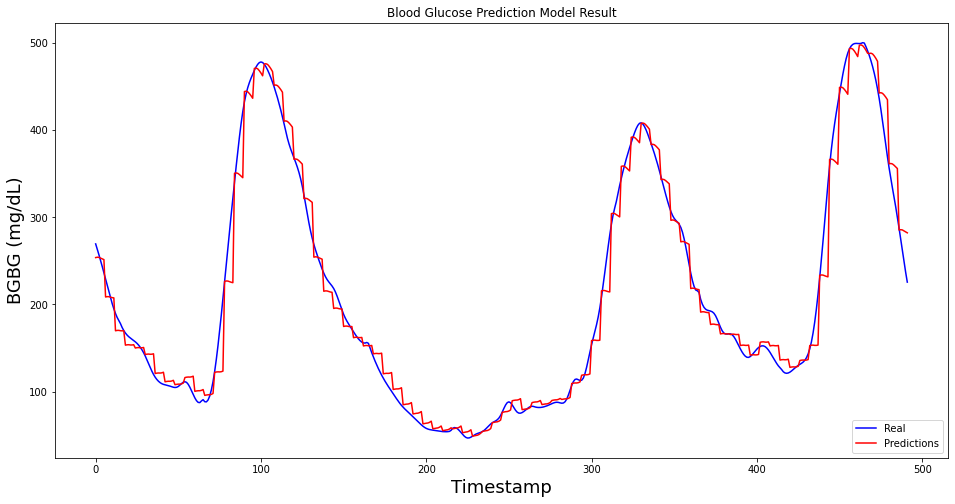

In [109]:
show_plots(continuous_ytest, continuous_predictions3)

In [110]:
print("Root-Mean-Squared Deviation {}".format(rmse3))

Root-Mean-Squared Deviation 19.092980207570132


In [111]:
rmse31, continuous_ytes31, continuous_predictions31 = test_model(model3)

### Patient 01 predictions

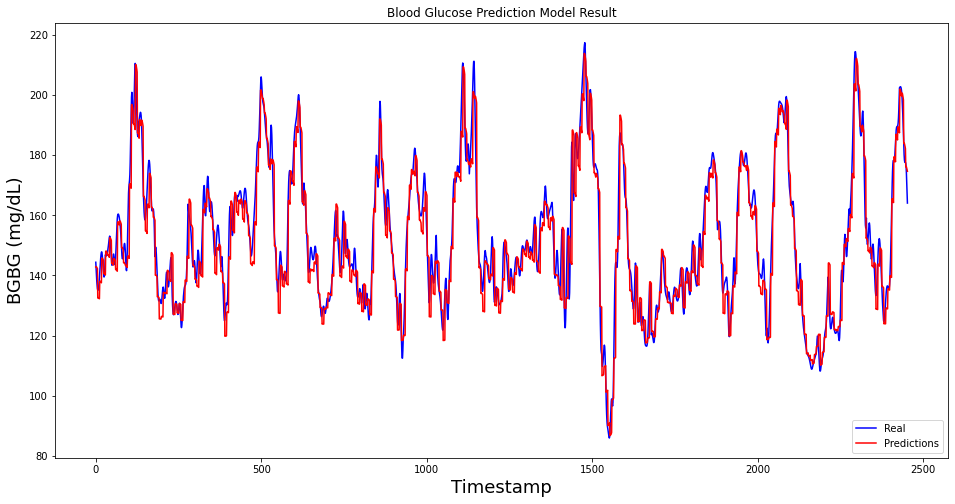

Root-Mean-Squared Deviation 7.0845371732449465


In [112]:
show_plots(continuous_ytes31, continuous_predictions31)
print("Root-Mean-Squared Deviation {}".format(rmse31))

In [113]:
rmse32, continuous_ytes32, continuous_predictions32 = test_model(model3,number="10")

### Patient 10 predictions

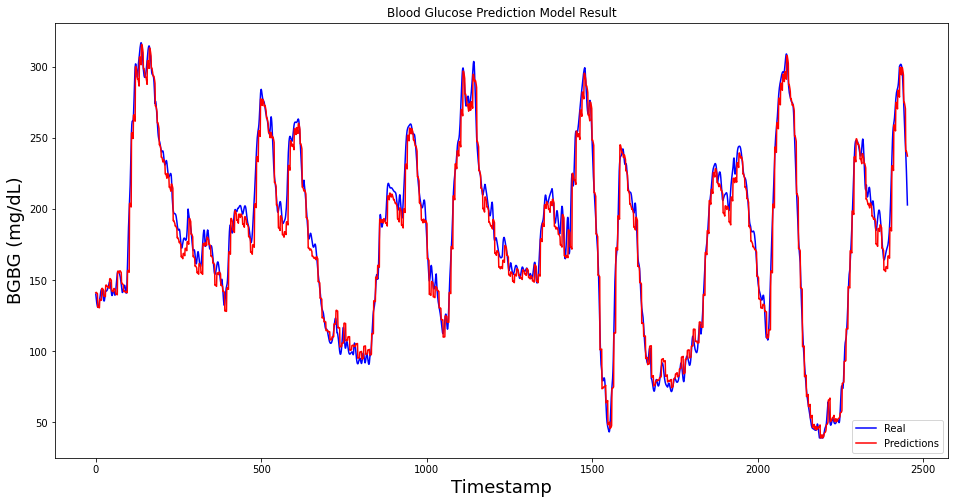

Root-Mean-Squared Deviation 9.700539848667114


In [114]:
show_plots(continuous_ytes32, continuous_predictions32)
print("Root-Mean-Squared Deviation {}".format(rmse32))

### Patient 07 predictions

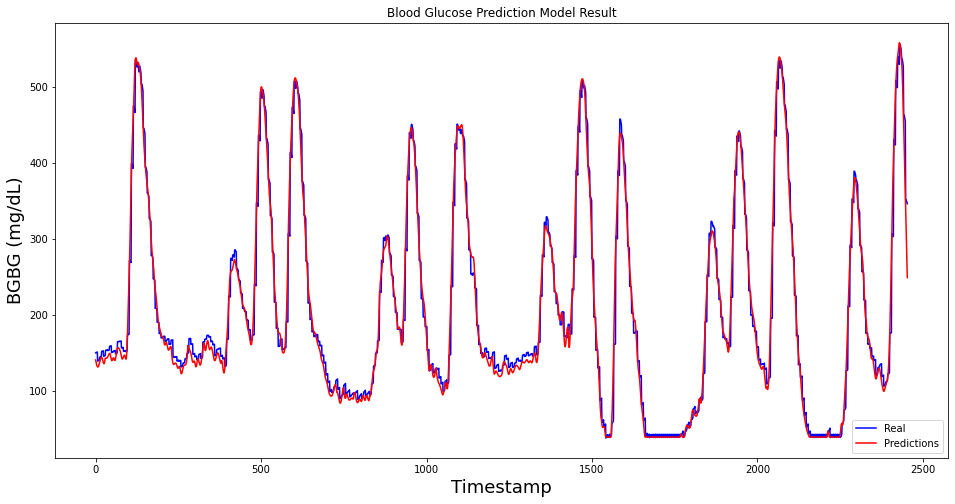

Root-Mean-Squared Deviation 17.804935924236602


In [115]:
rmse33, continuous_predictions33, continuous_ytes33 = test_model(model3,number="07")
show_plots(continuous_ytes33, continuous_predictions33)
print("Root-Mean-Squared Deviation {}".format(rmse33))